# Cat & Dog image Classification

2022.02.28 황성아

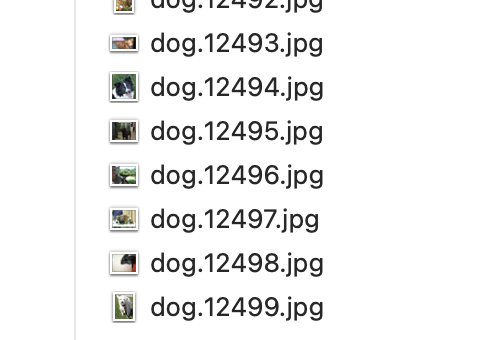

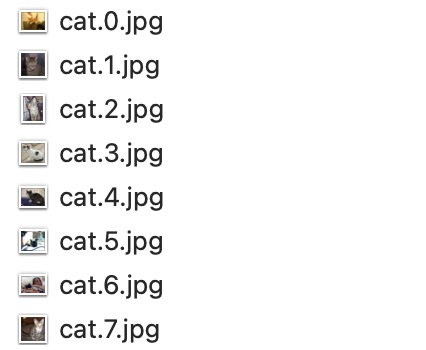

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import cv2
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import zipfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import warnings
warnings.filterwarnings('ignore')

## load data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
with zipfile.ZipFile('/content/gdrive/MyDrive/dogcat/train.zip', 'r') as zip_ref:
  zip_ref.extractall('./')

In [4]:
filenames = os.listdir('./train')

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if(category == 'dog'):    
        categories.append('dog')  
    else:   
        categories.append('cat')
        
# create a dataframe

df = pd.DataFrame({     
        'filename' : filenames, 
        'category' : categories 
    })

In [5]:
df.head()

,filename,category
0,dog.10496.jpg,dog
1,cat.1180.jpg,cat
2,dog.4375.jpg,dog
3,dog.2119.jpg,dog
4,dog.11736.jpg,dog


In [6]:
df['category'].value_counts()

dog    12500
cat    12500
Name: category, dtype: int64

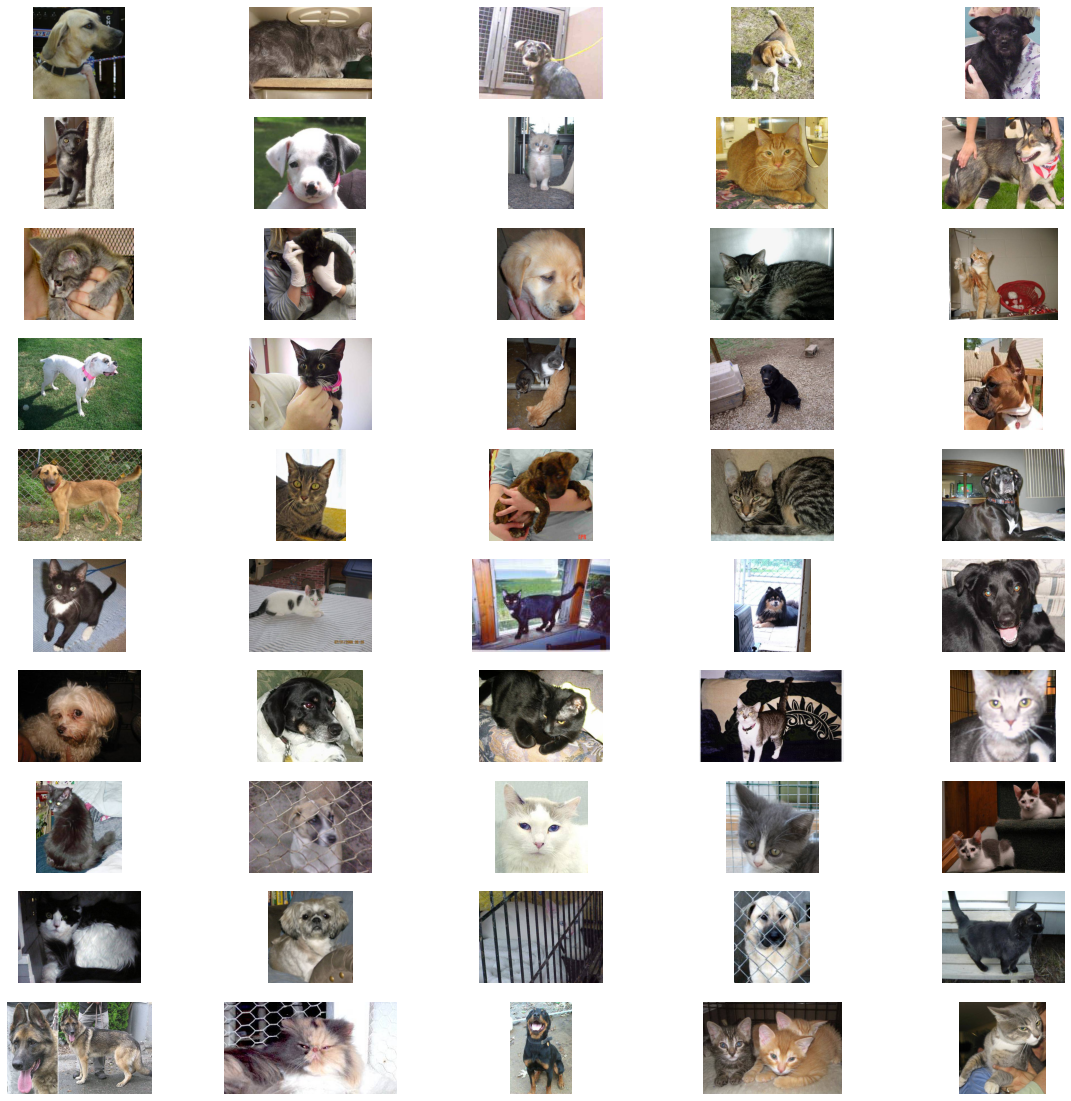

In [7]:
import PIL

fig = plt.figure(1, figsize = (20, 20))
for i in range(50):
    plt.subplot(10, 5, i + 1)
    pic = PIL.Image.open('./train/' + os.listdir('./train/')[i])
    plt.imshow(pic)
    plt.axis('off')

plt.show()

## Preprocessing

In [8]:
categories = ["cat", "dog"]
data_dir = "./train"
IMG_SIZE = 64

def create_img_array(data_dir):
    img_array_list = []
    label_list = []
    path = data_dir
        
    for img in tqdm(os.listdir(path)):
            
        try:  
            if img.startswith('cat'):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) 
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                img_array = img_to_array(img_array)
                img_array_list.append(img_array)
                label_list.append(0) # cat: 0
                
            elif img.startswith('dog'):
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                img_array = img_to_array(img_array)
                img_array_list.append(img_array)
                label_list.append(1) # dog: 1
                
                
        except Exception as e:
            print(str(e))
            
    return img_array_list, label_list

In [9]:
img, labels = create_img_array(data_dir) 
img = np.asarray(img) # list -> array
labels = np.array(labels) # list -> array

100%|██████████| 25000/25000 [00:32<00:00, 769.81it/s]


In [10]:
labels = to_categorical(labels, num_classes = 2)
labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [11]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(img, labels, random_state = 42, test_size = 0.2)

In [12]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(20000, 64, 64, 1)
(20000, 2)
(5000, 64, 64, 1)
(5000, 2)


## CNN

In [16]:
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape = (IMG_SIZE, IMG_SIZE, 1), activation = 'relu')) 
model.add(MaxPool2D(pool_size = (2, 2))) # pooling is to reduce the size of the images as much as possible, downsampling
model.add(Dropout(0.2))# dropout is a regularization technique to reduce overfitting, by giving each node a probability of being dropped
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2))) 
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())# get 1D array to feed into the Dense layer
model.add(Dense(units = 512, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 256, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 2, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
model_results = model.fit(train_x, train_y, epochs = 5, batch_size = 64, validation_data = (test_x, test_y), verbose = 1)

Epoch 1/5
313/313 [==============================] - 531s 2s/step - loss: 0.7320 - accuracy: 0.4969 - val_loss: 0.6970 - val_accuracy: 0.5024
Epoch 2/5
313/313 [==============================] - 527s 2s/step - loss: 0.7169 - accuracy: 0.5020 - val_loss: 0.6934 - val_accuracy: 0.4976
Epoch 3/5
313/313 [==============================] - 527s 2s/step - loss: 0.7103 - accuracy: 0.4963 - val_loss: 0.7021 - val_accuracy: 0.4976
Epoch 4/5
313/313 [==============================] - 528s 2s/step - loss: 0.7034 - accuracy: 0.5077 - val_loss: 0.6950 - val_accuracy: 0.5024
Epoch 5/5
313/313 [==============================] - 530s 2s/step - loss: 0.7007 - accuracy: 0.5020 - val_loss: 0.6945 - val_accuracy: 0.4976


In [19]:
score, acc = model.evaluate(test_x, test_y, batch_size = 64)
print(acc)

79/79 [==============================] - 30s 380ms/step - loss: 0.6945 - accuracy: 0.4976
0.4975999891757965


In [20]:
pred = model.predict(test_x)
pred

array([[0.4542795, 0.5457205],
       [0.4542795, 0.5457205],
       [0.4542795, 0.5457205],
       ...,
       [0.4542795, 0.5457205],
       [0.4542795, 0.5457205],
       [0.4542795, 0.5457205]], dtype=float32)

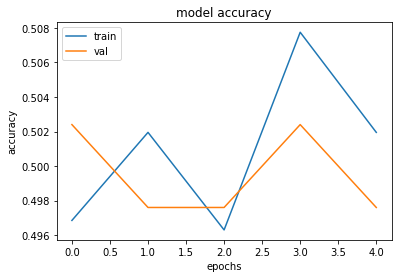

In [21]:
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

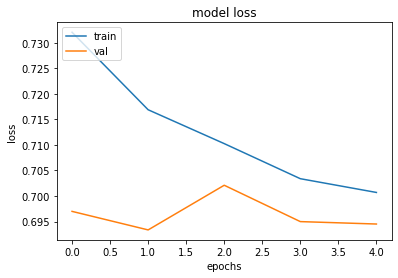

In [22]:
plt.plot(model_results.history['loss'])
plt.plot(model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

## VGG16

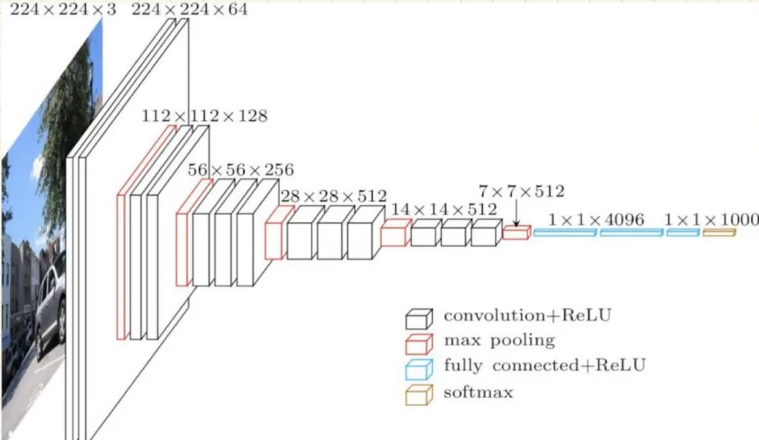

In [23]:
VGG = Sequential()
# Convolution Layer 1
VGG.add(Conv2D(input_shape=(IMG_SIZE, IMG_SIZE,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# Max Pooling Layer 1
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Convolution Layer 2
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# Max Pooling Layer 2
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Convolution Layer 3
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# Max Pooling Layer 3
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Convolution Layer 4
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# Max Pooling Layer 4
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# Convolution Layer 5
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# Max Pooling Layer 5
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
# Flatten Layer
VGG.add(Flatten(name='flatten'))
# 3 Dense Layers
VGG.add(Dense(4096, activation='relu', name='fc1'))
VGG.add(Dense(4096, activation='relu', name='fc2'))
VGG.add(Dense(2, activation='sigmoid', name='output'))

In [24]:
VGG.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [25]:
VGG.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [93]:
history2 = VGG.fit(train_x, train_y, epochs = 1, batch_size = 64, validation_data = (test_x, test_y), verbose = 1)

313/313 [==============================] - 4004s 13s/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4976


In [96]:
score, acc = VGG.evaluate(test_x, test_y, batch_size = 64)
print(acc)

79/79 [==============================] - 225s 3s/step - loss: 0.6932 - accuracy: 0.4976
0.4975999891757965


In [97]:
pred = VGG.predict(test_x)
pred

array([[0.49790096, 0.5022607 ],
       [0.49790096, 0.5022607 ],
       [0.49790096, 0.5022607 ],
       ...,
       [0.49790096, 0.5022607 ],
       [0.49790096, 0.5022607 ],
       [0.49790096, 0.5022607 ]], dtype=float32)

### Data Augmentation

In [158]:
CONTENT_DIR = '/kaggle/content'

TRAIN_DIR = CONTENT_DIR + '/train'
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR = CONTENT_DIR + '/valid'
VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

if not os.path.exists(CONTENT_DIR):
    import zipfile
    with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zipf:
        zipf.extractall(CONTENT_DIR)

    # Split cats and dogs images to train and valid datasets
    img_filenames = os.listdir(TRAIN_DIR)
    print('Num of images:', len(img_filenames))

    dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
    cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]

    dataset_filenames = train_test_split(
        dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
    )

    train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
    train_total = train_dog_total + train_cat_total
    valid_total = valid_dog_total + valid_cat_total
    print('Train: {}, test: {}'.format(train_total, valid_total))

    # Move images
    make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
    for dir, fns in zip(make_dirs, dataset_filenames):
        os.makedirs(dir, exist_ok=True)
        for fn in tqdm.tqdm(fns):
            shutil.move(os.path.join(TRAIN_DIR, fn), dir)
        print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

In [159]:
BATCH_SIZE = 128
IMAGE_SHAPE = 128

In [160]:
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for img, ax in zip(images, axes.flatten()):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()   

In [161]:
def show_augmentation(generator):
    image_data = image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
        batch_size=BATCH_SIZE,
        shuffle= True
    )
    augmented_images = [image_data[0][0][0] for _ in range(5)]
    plot_images(augmented_images)

### Horisontal flipping

수펑 뒤집기

* rescale=1./255: 이미지 크기 조정(정규화과정)
현재 이미지 데이터는 0부터 255의 RGB값을 가지고 있어서 255로 나누어 0~1 값으로 변환시킴

Found 22500 images belonging to 2 classes.


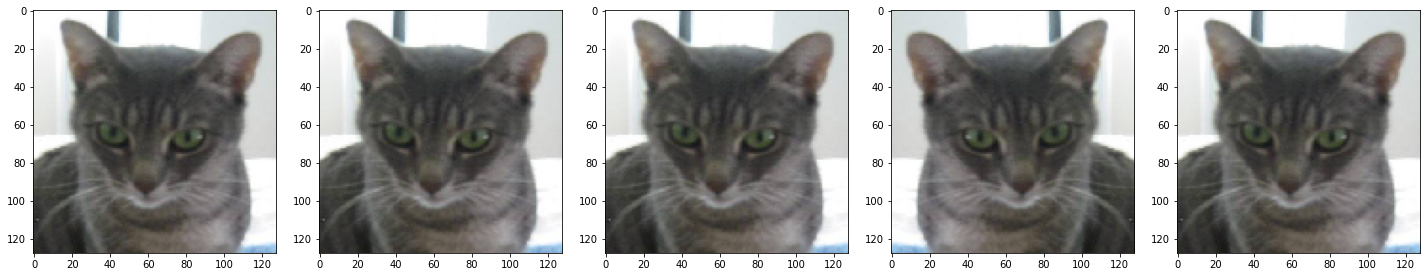

In [162]:
image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
show_augmentation(image_generator)

### Rotation

회전

Found 22500 images belonging to 2 classes.


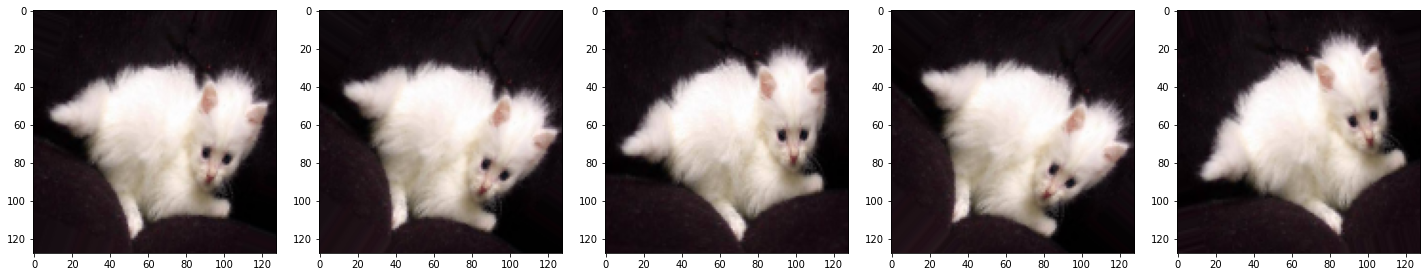

In [163]:
image_generator = ImageDataGenerator(rescale=1./255, rotation_range=45)
show_augmentation(image_generator)

### Zoom

확대.축소

Found 22500 images belonging to 2 classes.


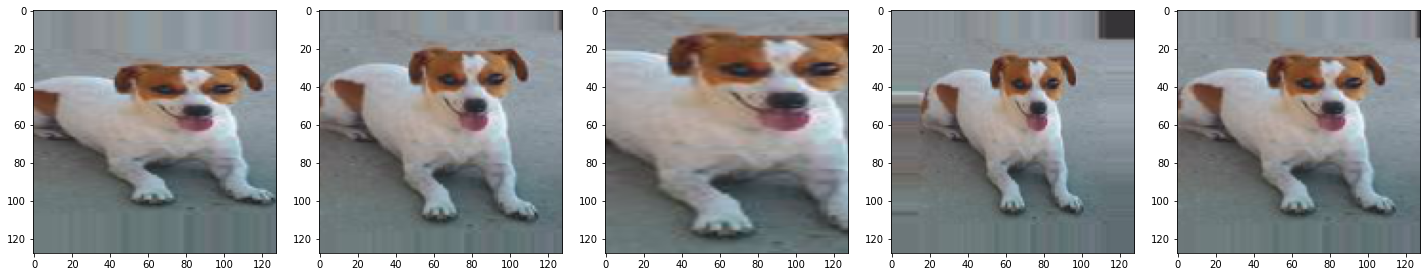

In [164]:
image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
show_augmentation(image_generator)

Found 0 images belonging to 0 classes.
Found 22500 images belonging to 2 classes.


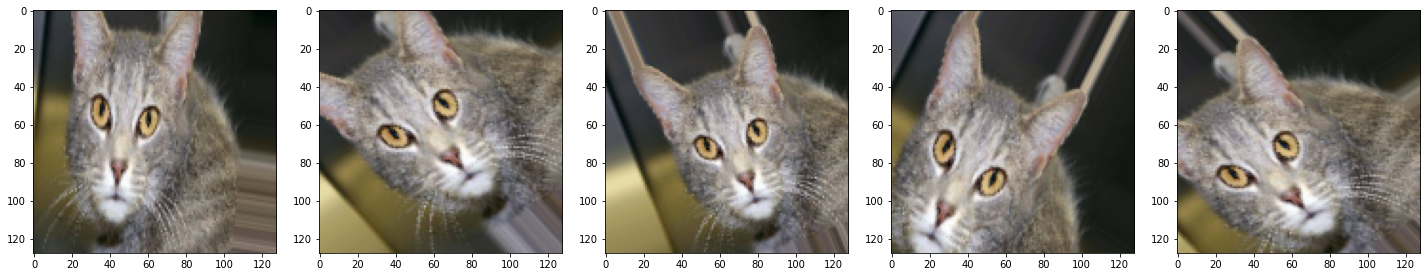

In [165]:
image_generator = ImageDataGenerator(
    rotation_range= 40, # 회전
    width_shift_range=0.2, # 폭 이동
    height_shift_range=0.2, # 높이 이동
    zoom_range=0.2, # 확대.축소
    horizontal_flip=True, # 수평으로 뒤집기
    rescale=1./255
)
train_data = image_generator.flow_from_directory(
    directory='./train',
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary'
)
show_augmentation(image_generator)